In [2]:
import os
import glob
import cv2
import pygad
import time
import shap
import json
import random

import numpy as np

import skimage.io as io
from skimage.draw import polygon
from skimage.transform import resize
from pycocotools.coco import COCO
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.cm import get_cmap
from matplotlib.patches import Polygon

import seaborn as sns
sns.set(font_scale=1.2, style='white')

import warnings
warnings.simplefilter("ignore")

seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

from cmcrameri import cm

# ResNet50 on ImageNet classification

In [3]:
# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

In [4]:
# image size for ResNet50
size = (224, 224)

In [5]:
batlow_cmap = cm.batlow

In [6]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

In [7]:
# some test images
image_paths = sorted(glob.glob('./test_images/*.jpeg'))

In [8]:
def display_images(image_paths):
    """
    Display images without additional annotations.

    Parameters:
    - image_paths (list): List of file paths to the images to be displayed.

    Returns:
    None

    The function displays images from the provided file paths in a grid layout without any additional
    annotations or predictions. It reads and decodes each image using TensorFlow and displays them
    in a grid.

    Note:
    - The images are displayed in the order they appear in the 'image_paths' list.
    """
    
    num_images = len(image_paths)
    num_columns = min(4, num_images)
    num_rows = int(np.ceil(num_images / num_columns))

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))

    for idx, image in enumerate(image_paths):
        
        # Read the image using TensorFlow.
        tf_image = tf.io.read_file(image)

        # Decode the above `tf_image` from a Bytes string to a numeric Tensor.
        decoded_image = tf.image.decode_image(tf_image)
        
        # show image
        ax = axes if num_columns == 1 else axes.flat[idx]
        ax.imshow(decoded_image)
        ax.axis('off')

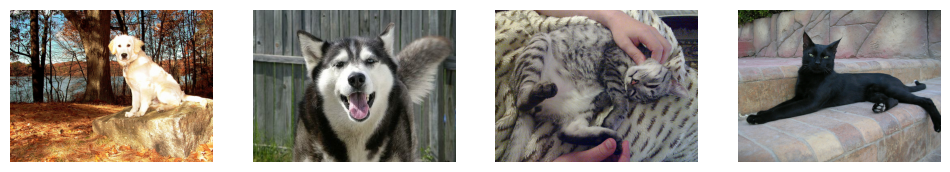

In [9]:
# testing display image
display_images(image_paths)

In [10]:
def load_images(image_paths, model, size):
    """
    Load a batch of images.

    Parameters:
    - image_paths (list): List of file paths to the images to be loaded.
    - model (tf.keras.Model): The TensorFlow Keras model for which the images are being prepared.
    - size (tuple): The target spatial size (height, width) required by the model.

    Returns:
    tf.Tensor: A batch of images ready to be preprocessed and then fed into the specified model.

    The function reads each image from the given file paths, decodes it, resizes it to the
    specified spatial size, adds a batch dimension. The resulting batch of loaded images is returned.

    Note:
    Make sure that the model's preprocess_input function is called after this.     
    """
    
    image_list = []
    
    for image_path in image_paths:
        
        # Read the image using TensorFlow.
        tf_image = tf.io.read_file(image_path)

        # Decode the above `tf_image` from a Bytes string to a numeric Tensor.
        decoded_image = tf.image.decode_image(tf_image)

        # Resize the image to the spatial size required by the model.
        image_resized = tf.image.resize(decoded_image, size)

        # Pre-process the input image.
        image_list.append(image_resized)
    
    # stack all preprocessed images in a tensor of shape (num_images, size, size, 3)
    image_batch = tf.stack(image_list, axis=0)
    
    return image_batch

In [11]:
def predict(image_batch, model, top_k=3):
    """
    Make predictions for a batch of images using the specified model.

    Parameters:
    - image_batch (numpy.ndarray or tf.Tensor): A batch of preprocessed images ready to be fed into the model.
    - model (tf.keras.Model): The TensorFlow Keras model used for predictions.
    - top_k (int): The number of top predicted classes to return.

    Returns:
    List: A list of lists of top class prediction tuples (class_name, class_description, score)
    for each sample in the batch.

    The function performs a forward pass through the provided model to make predictions on the input
    image batch. It decodes and ranks the top-k predictions, returning a list of lists of top class prediction
    tuples for each image in the batch.

    Note:
    - The input images are assumed to be preprocessed and ready for model inference.
    - The `decode_predictions` function is used to convert model predictions into human-readable labels.
    """
    
    # Forward pass through the model to make predictions
    preds = model.predict(image_batch, verbose=0)
    
    # Decode (and rank the top-k) predictions. 
    # Returns a list of lists of top class prediction tuples (class_name, class_description, score). 
    # One list of tuples per sample in batch input.
    decoded_preds = decode_predictions(preds=preds, top=top_k)
        
    return decoded_preds

In [12]:
def display_predictions(image_paths, decoded_preds, top_k=3, filename=None):
    """
    Display images along with their top predicted classes and scores.

    Parameters:
    - image_paths (list): List of file paths to the images to be displayed.
    - decoded_preds (list): A list of lists of top class prediction tuples (class_name, class_description, score)
      for each image in the batch.
    - top_k (int): The number of top predicted classes to display.

    Returns:
    None

    The function displays images along with their top-k predicted classes and scores in a grid layout.
    The input images are loaded from the provided file paths, and the predictions are obtained from
    the decoded predictions list.

    Note:
    - The decoded_preds list should correspond to the predictions for the provided image paths.
    - Ensure that the number of image paths matches the length of the decoded_preds list.
    """
        
    num_images = len(image_paths)
    num_columns = min(4, num_images)
    num_rows = int(np.ceil(num_images / num_columns))

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))

    for idx, pred in enumerate(decoded_preds):
        
        # Read the image using TensorFlow.
        tf_image = tf.io.read_file(image_paths[idx])

        # Decode the above `tf_image` from a Bytes string to a numeric Tensor.
        decoded_image = tf.image.decode_image(tf_image)
        
        # show image
        ax = axes if num_columns == 1 else axes.flat[idx]
        ax.imshow(decoded_image)
        ax.axis('off')
        
        title = ''
        
        for jdx in range(top_k):
            label = decoded_preds[idx][jdx][1]
            score = decoded_preds[idx][jdx][2]
            true_label_code = image_paths[idx].split('/')[-1].split("_")[0]
            if jdx==0 and decoded_preds[idx][jdx][0]==true_label_code:
                print("ground_truth =",label)
            title += label + ' ' + str('{:.2f}'.format(score)) + '\n'

        # add classes
#         ax.set_title(title)
        print(title)
        
        if filename is not None:
            plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')

golden_retriever 0.80
Labrador_retriever 0.17
kuvasz 0.03

Eskimo_dog 0.53
Siberian_husky 0.40
malamute 0.07

Egyptian_cat 0.98
snow_leopard 0.02
tabby 0.00

kelpie 0.39
Egyptian_cat 0.30
schipperke 0.20



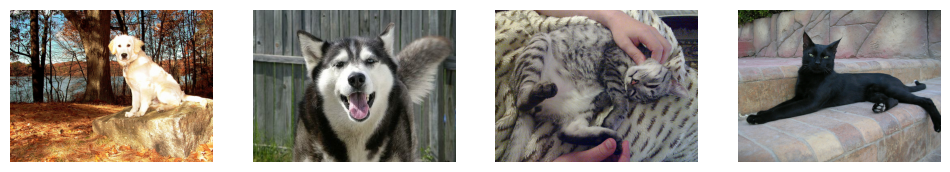

In [13]:
# testing predictions and display

image_batch = load_images(image_paths, model, size)
image_batch = preprocess_input(image_batch)
decoded_preds = predict(image_batch, model, top_k=3)
display_predictions(image_paths, decoded_preds, top_k=3)

# PartImageNet segmentation dataset

In [14]:
# Load annotations for the images
annotations_path = './PartImageNet_Seg/PartImageNet/annotations/train/'
images_folder = './PartImageNet_Seg/PartImageNet/images/train/'
annFile = annotations_path + 'train.json'

# initialize COCO api for instance annotations
coco=COCO(annFile)

# display categories and supercategories
categories = coco.loadCats(coco.getCatIds())
names = [categ['name'] for categ in categories]
print('\nCOCO categories:')
print(names)

names = set([categ['supercategory'] for categ in categories])
print('\nCOCO supercategories:')
print(names)

loading annotations into memory...
Done (t=3.10s)
creating index...
index created!

COCO categories:
['Quadruped Head', 'Quadruped Body', 'Quadruped Foot', 'Quadruped Tail', 'Biped Head', 'Biped Body', 'Biped Hand', 'Biped Foot', 'Biped Tail', 'Fish Head', 'Fish Body', 'Fish Fin', 'Fish Tail', 'Bird Head', 'Bird Body', 'Bird Wing', 'Bird Foot', 'Bird Tail', 'Snake Head', 'Snake Body', 'Reptile Head', 'Reptile Body', 'Reptile Foot', 'Reptile Tail', 'Car Body', 'Car Tier', 'Car Side Mirror', 'Bicycle Body', 'Bicycle Head', 'Bicycle Seat', 'Bicycle Tier', 'Boat Body', 'Boat Sail', 'Aeroplane Head', 'Aeroplane Body', 'Aeroplane Engine', 'Aeroplane Wing', 'Aeroplane Tail', 'Bottle Mouth', 'Bottle Body']

COCO supercategories:
{'Boat', 'Quadruped', 'Reptile', 'Biped', 'Bicycle', 'Car', 'Fish', 'Bird', 'Aeroplane', 'Bottle', 'Snake'}


In [15]:
def load_PartImageNet_image(v, categories, coco, filename=None):
    """
    Load information about a specific image in the PartImageNet dataset based on its filename.

    Parameters:
    - img_filename (str): The filename of the image to be loaded.
    - categories (list of str): List of category names to filter the images.
    - coco (COCO): The COCO API object initialized with the PartImageNet dataset.
    - display_annotations (bool): If True, display annotations for the loaded image.

    Returns:
    dict: A dictionary containing information about the specified image in the PartImageNet dataset.

    This function filters images in the PartImageNet dataset based on the provided categories,
    then retrieves the information about the image with the specified filename. The returned
    dictionary includes details such as image ID, file name, height, width, and other metadata.
    
    If 'display_annotations' is True, it also shows annotations for the loaded image.
    """
    
    # get all images containing given categories
    categIds = coco.getCatIds(catNms=categories)
    imgIds = coco.getImgIds(catIds=categIds)

    # look for image based on filename
    for i in imgIds:
        img = coco.loadImgs(i)[0] # specific image by id
        if img['file_name'] == img_filename:
            break
            
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=categIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    I = io.imread(images_folder + img['file_name'])
    plt.imshow(I)
    plt.axis('off')
    coco.showAnns(anns)

    plt.savefig('figures/' + filename + ".pdf", dpi=400, bbox_inches='tight')
    
    return img, anns


def load_rand_PartImageNet_image(categories, coco, filename=None):
    """
    Load information about a randomly selected image in the PartImageNet dataset.

    Parameters:
    - categories (list of str): List of category names to filter the images.
    - coco (COCO): The COCO API object initialized with the PartImageNet dataset.
    - display_annotations (bool): If True, display annotations for the loaded image.

    Returns:
    dict: A dictionary containing information about a randomly selected image in the PartImageNet dataset.

    This function retrieves all images containing the given categories and selects a random image from
    the list. It returns a dictionary containing information about the randomly selected image.
    
    If 'display_annotations' is True, it also shows annotations for the loaded image.
    """
    # get all images containing given categories
    categIds = coco.getCatIds(catNms=categories)
    imgIds = coco.getImgIds(catIds=categIds)

    # random image taken from list
    img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=categIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    I = io.imread(images_folder + img['file_name'])
    plt.imshow(I)
    plt.axis('off')
    coco.showAnns(anns)

    if filename is not None:
        plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')
    
    print(img['file_name'])
    return img, anns

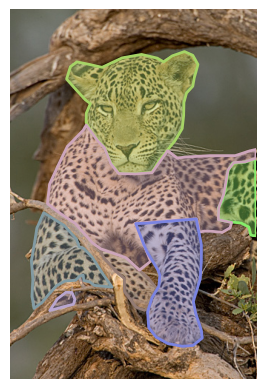

In [16]:
# testing load segments

img_filename = 'n02128385_12801.JPEG' # leopard
# img_filename = 'n02112137_10766.JPEG' # chow
# img_filename = 'n02101006_17524.JPEG' # Gordon_setter (dog)
# img_filename = 'n02442845_3823.JPEG' # mink

img, anns = load_PartImageNet_image(img_filename, categories, coco, filename=img_filename.replace(".JPEG","")+"_part")

# sel_categories = ['Quadruped Head', 'Quadruped Body', 'Quadruped Foot', 'Quadruped Tail']
# img, anns = load_rand_PartImageNet_image(sel_categories, coco, filename=None)

In [17]:
def create_mask_from_seg(img, anns):
    """
    Create a mask with unique integer labels for each segment based on annotations.

    Parameters:
    - img (dict): A dictionary containing information about the image (e.g., height, width).
    - anns (list): A list of annotations containing segmentation information.

    Returns:
    numpy.ndarray: A 2D array representing the mask with unique integer labels for each segment.

    This function generates a mask with unique integer labels for each segment defined by the provided
    annotations. It assumes a single segmentation polygon for each annotation and assigns a unique label
    to each segment in the mask. The resulting mask has the same dimensions as the image.
    """
    mask = np.zeros((img['height'], img['width']), dtype=np.int32)

    for i, ann in enumerate(anns):
        seg = ann['segmentation'][0]  # Assuming a single segmentation polygon
        rr, cc = polygon(seg[1::2], seg[0::2])  # Convert polygon to pixel coordinates
        mask[rr, cc] = i + 1  # Assign a unique label to the segment
        
    return mask

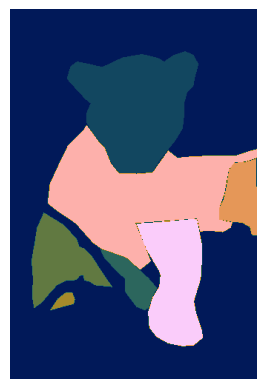

In [70]:
# testing mask
mask = create_mask_from_seg(img, anns)

plt.imshow(mask, cmap=batlow_cmap)  # Use a colormap for visualization
plt.axis('off')
plt.show()

In [105]:
def display_mask_over_image(img, mask, alpha=1.0, filename=None):

    # Rescale heatmap to a range 0-255
    min_value = np.min(mask)
    max_value = np.max(mask)
    heatmap = np.uint8(255 * (mask - min_value) / (max_value - min_value))

    # Use jet colormap to colorize heatmap
    cmap = batlow_cmap

    # Use RGB values of the colormap
    cmap_colors = cmap(np.arange(256))[:, :3]
    cmap_heatmap = cmap_colors[heatmap]

    # Resize heatmap
    cmap_heatmap = array_to_img(cmap_heatmap)
    cmap_heatmap = cmap_heatmap.resize((img.shape[1], img.shape[0]))
    cmap_heatmap = img_to_array(cmap_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = cmap_heatmap * alpha + img * 0.15
    superimposed_img = array_to_img(superimposed_img)

    plt.figure()
    ps = plt.imshow(superimposed_img, cmap=batlow_cmap)
#     cb = plt.colorbar(ps)
#     cb.set_ticks([])
    plt.axis('off')
    # plt.show()
    
    if filename is not None:
        plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')

## Classification of PartImageNet with ResNet

ground_truth = leopard
leopard 0.99
cheetah 0.01
jaguar 0.01



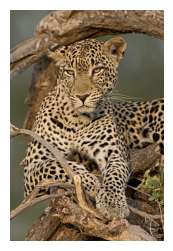

In [20]:
# testing classification
image_file = images_folder + img['file_name']
image_paths = [image_file]

image_batch = load_images(image_paths, model, size)
image_batch = preprocess_input(image_batch)
decoded_preds = predict(image_batch, model, top_k=3)
display_predictions(image_paths, decoded_preds, top_k=3, 
                    filename=img['file_name'].replace(".JPEG","")+"_pred")

### Classification and occlusion plots

In [21]:
def display_blurred_seg_pred(img, mask, model, label, permutation=None, filename=None):
    """
    Blurs the image based on the mask, segment by segment, and display the predictions.

    Parameters:
    - img (dict): A dictionary containing information about the image.
    - mask (numpy.ndarray): The segmentation mask containing unique integer labels.
    - model (tf.keras.Model): The TensorFlow Keras model for prediction.
    - label (str): The class label for which predictions are displayed.
    - permutation (list): A list specifying the order of segment blurring. Default is None.

    Displays a grid of images where each row corresponds to a different segmentation mask.
    The images are created by successively blurring each segment of the input image and
    predicting the class label using the specified model. The original image is displayed
    in the first row, and subsequent rows show the effects of blurring each segment individually.
    """

    num_segments = np.max(mask)  # Assuming mask contains unique integer labels
    if permutation is None:
        permutation = list(range(0, num_segments + 1))
    segment_list = [-1] + permutation # -1 for the original (no changes in mask)

    # Load and convert the image to a NumPy array for Gaussian blur
    file = images_folder + img['file_name']
    tf_image = tf.io.read_file(file)
    decoded_image = tf.image.decode_image(tf_image)
    image_np = decoded_image.numpy()
    
    num_images = len(segment_list)
    
    # for the leopard figures
    num_columns = min(5, num_images)
    #
    # for appendices
#     num_columns = min(1, num_images)
    #
    
    num_rows = int(np.ceil(num_images / num_columns))

    # for the leopard figures
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(2 * num_columns, 3 * num_rows))
    # 
    # for appendices
#     fig, axes = plt.subplots(num_rows, num_columns, figsize=(2 * num_columns, 2 * num_rows))
    #

    for idx, segment_label in enumerate(segment_list): 

        # Create a mask for the current segment
        segment_mask = (mask == segment_label)

        # Resize the segment mask to match the image shape
        resized_segment_mask = np.zeros_like(image_np, dtype=bool)
        resized_segment_mask[:segment_mask.shape[0], :segment_mask.shape[1], :] = segment_mask[..., np.newaxis]

        # Create Gaussian blur and update the original image with the blurred segment
        blurred_segment = gaussian_filter(image_np, sigma=5)
        image_np = np.where(resized_segment_mask, blurred_segment, image_np)

        # Convert the updated image back to a TensorFlow tensor
        decoded_image = tf.convert_to_tensor(image_np)

        # Resize the image to the spatial size required by the model.
        image_resized = tf.image.resize(decoded_image, size)

        # Add a batch dimension to the first axis (required). 
        image_batch = tf.expand_dims(image_resized, axis=0)

        # Pre-process and predict the input image.
        image_batch = preprocess_input(image_batch)
        decoded_preds = predict(image_batch, model, top_k=1000)
        
        if segment_label == -1: #original image
            label_index = 0
        else:
            # Find the index of the original label in the predictions
            label_index = -1
            for jdx, (class_id, class_desc, prob) in enumerate(decoded_preds[0]):
                if class_desc == label:
                    label_index = jdx
                    break

#         ax = axes if num_columns == 1 else axes.flat[idx]
        ax = axes.flat[idx]
        ax.imshow(image_np)
        label = decoded_preds[0][label_index][1]
        score = decoded_preds[0][label_index][2]
        title = str('{:.2f}'.format(score))
        ax.set_title(title)
#         ax.axis('off')
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        if idx == 0: # Only add y-axis label to the first subplot
            ax.set_ylabel(label)
        
    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()] # removing empty subplots
    
    if filename is not None:
        plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')

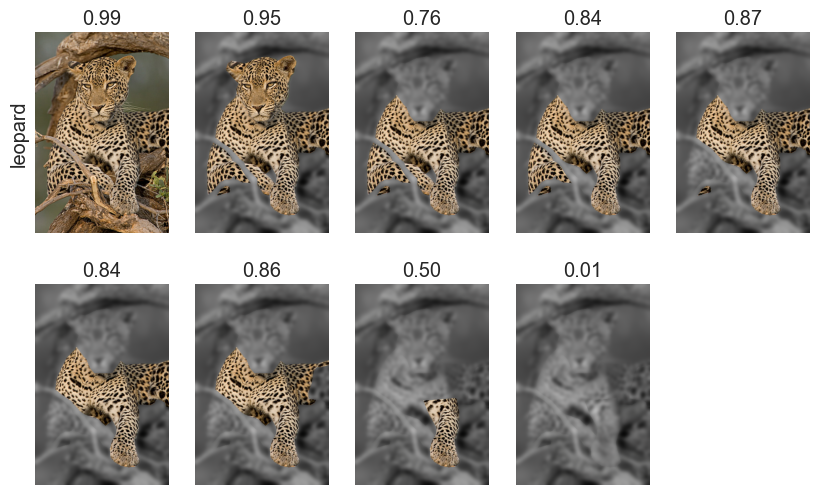

In [22]:
# testing blur prediction

label = decoded_preds[0][0][1]
display_blurred_seg_pred(img, mask, model, label, permutation=None, 
                         filename=img['file_name'].replace(".JPEG","")+"_baseline_blur")

## GA feature importance curves

In [23]:
def fit_value(img, mask, model, label, permutation):
    """
    Compute the AUC and points for the feature flipping curve associated with a permutation.

    Parameters:
    - img (dict): Information about the image, including the file name.
    - mask (numpy.ndarray): The segmentation mask associated with the image.
    - model (tf.keras.Model): The TensorFlow Keras model for prediction.
    - label (str): The target label for which the fitness is computed.
    - permutation (list): The permutation used for feature flipping.

    Returns:
    tuple: A tuple containing the fitness value and the list of values.

    This function computes the area under the curve (AUC) and values for the feature flipping curve
    associated with the given permutation. It performs feature flipping by progressively blurring
    image segments based on the permutation, predicts the modified images, and calculates the AUC
    along with the values for the specified target label. The fitness value is a combination of the
    AUC and a penalty term for non-monotonic changes in the values.
    """
    
    # Load and convert the image to a NumPy array for Gaussian blur
    file = images_folder + img['file_name']
    tf_image = tf.io.read_file(file)
    decoded_image = tf.image.decode_image(tf_image)
    image_np = decoded_image.numpy()
    
    lambda_penalty = 0.001
    w_ = np.array(range(len(permutation),0,-1))
    g_values = []
    
    X_copy = tf.identity(tf_image) # deep copy of a tensor
    
    for segment_label in permutation:
        
        # Create a mask for the current segment
        segment_mask = (mask == segment_label)

        # Resize the segment mask to match the image shape
        resized_segment_mask = np.zeros_like(image_np, dtype=bool)
        resized_segment_mask[:segment_mask.shape[0], :segment_mask.shape[1], :] = segment_mask[..., np.newaxis]

        # Create Gaussian blur and update the original image with the blurred segment
        blurred_segment = gaussian_filter(image_np, sigma=5)
        image_np = np.where(resized_segment_mask, blurred_segment, image_np)

        # Convert the updated image back to a TensorFlow tensor
        decoded_image = tf.convert_to_tensor(image_np)

        # Resize the image to the spatial size required by the model.
        image_resized = tf.image.resize(decoded_image, size)

        # Add a batch dimension to the first axis (required). 
        image_batch = tf.expand_dims(image_resized, axis=0)

        # Pre-process and predict the input image.
        image_batch = preprocess_input(image_batch)
        decoded_preds = predict(image_batch, model, top_k=1000)

        # Find the index of the original label in the predictions
        label_index = -1
        for idx, (class_id, class_desc, prob) in enumerate(decoded_preds[0]):
            if class_desc == label:
                label_index = idx
                break
                
        score = decoded_preds[0][label_index][2]        
        g_values.append(score)

    area_under_curve = np.sum(w_ * g_values)
    fitness = (area_under_curve + lambda_penalty * np.sum(np.maximum(np.diff(g_values), 0)))
    
    return fitness, g_values

def fitness_func(ga_instance, solution, solution_idx):
    """
    Fitness function for a genetic algorithm.

    Parameters:
    - ga_instance (pygad.GA): The genetic algorithm instance.
    - solution (list): The solution representing a permutation.
    - solution_idx (int): The index of the solution in the population.

    Returns:
    float: The fitness value for the given solution.

    This function evaluates the fitness of a solution (permutation) for a genetic algorithm. It
    calls the `fit_value` function to compute the AUC and values for the feature flipping curve
    associated with the solution and then calculates the fitness as the reciprocal of the AUC
    for maximization.
    """
    
    auc, _ = fit_value(img, mask, model, label, solution)
    fitness = 1.0 / (auc + 0.000001) # for maximization
    return fitness

In [24]:
# parameters for evaluating fitness
image = img
mask = mask
model = model
label = label
baseline = decoded_preds[0][0][2]

In [25]:
# GA hyperparameters
fitness_function = fitness_func

num_generations = 20
sol_per_pop = 10
num_parents_mating = 4

num_genes = len(anns) + 1 # number of segments + background

init_range_low = 0
init_range_high = len(anns)
gene_type = int
allow_duplicate_genes=False
gene_space = range(0, len(anns) + 1)

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

parallel_processing = 8

last_fitness = 0
def on_generation(ga_instance):
    global last_fitness
    print(f"Generation = {ga_instance.generations_completed}")
    print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
    print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

In [26]:
# create GA
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type = gene_type,
                       gene_space = gene_space,
                       allow_duplicate_genes=allow_duplicate_genes,
                       on_generation=on_generation,
                       parallel_processing = parallel_processing)

In [27]:
# testing GA
start_time = time.time()
ga_instance.run()
print("--- %s seconds ---" % (time.time() - start_time))

Generation = 1
Fitness    = 0.07084493359308229
Change     = 0.07084493359308229
Generation = 2
Fitness    = 0.07084493359308229
Change     = 0.0
Generation = 3
Fitness    = 0.07084799358348223
Change     = 3.059990399942314e-06
Generation = 4
Fitness    = 0.07091448533298418
Change     = 6.649174950194847e-05
Generation = 5
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 6
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 7
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 8
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 9
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 10
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 11
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 12
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 13
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 14
Fitness    = 0.07091448533298418
Change     = 0.0
Generation = 15
Fitness    = 0.07

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


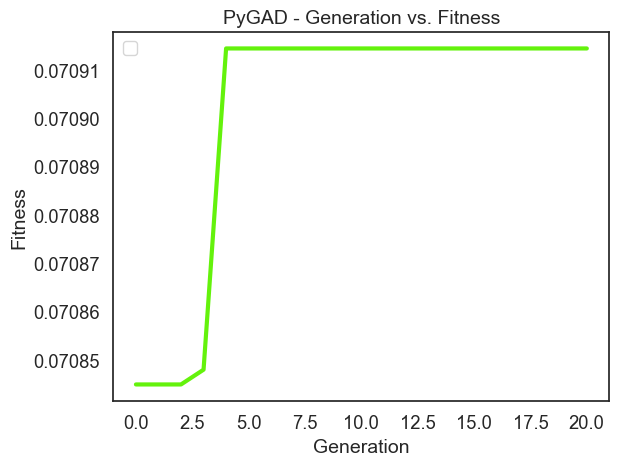

In [28]:
ga_instance.plot_fitness()
plt.show()

In [29]:
# Returning the details of the best solution.
best_permutation, solution_fitness, _ = ga_instance.best_solution(ga_instance.last_generation_fitness)
print(f"Parameters of the best solution : {best_permutation}")
print(f"Fitness value of the best solution = {solution_fitness}")

Parameters of the best solution : [1 7 3 5 2 6 0 4]
Fitness value of the best solution = 0.07091448533298418


In [30]:
def plot_feature_flipping(method_names, g_values_list, filename=None):
    """
    Plot the feature flipping curves for multiple methods.

    Parameters:
    - method_names (list): List of method names for labeling the curves.
    - g_values_list (list): List of lists containing G-values for each method.

    This function generates a plot visualizing feature flipping curves for different methods.
    It takes a list of method names and their corresponding G-values and creates a line plot,
    where each curve represents a method. The x-axis represents the feature flipping index,
    and the y-axis represents the associated G-values. The area under the curves is filled with grey.

    Example:
    ```python
    method_names = ['Method A', 'Method B']
    g_values_list = [[0.5, 0.7, 0.6], [0.3, 0.4, 0.5]]
    plot_feature_flipping(method_names, g_values_list)
    plt.show()
    ```
    """
    
    fig, ax = plt.subplots()
    for idx, method in enumerate(method_names):
        
        g_values = [baseline] + g_values_list[idx]
        
        x_data = np.array(range(0, len(g_values)))

        ax.plot(x_data, g_values, marker='o', 
                markersize=10, linestyle='--', color='0.2', markerfacecolor=sns.color_palette()[idx], label=method)

    ax.set_xlabel('$\pi_i$')
    ax.set_ylabel('$g(\pi_i)$')
    ax.legend()

    # Fill the area under the curve with grey
    ax.fill_between(x_data, np.min(g_values), g_values, 
                    where=(g_values >= np.min(g_values)), color='grey', alpha=0.2)
    
    if filename is not None:
        plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')

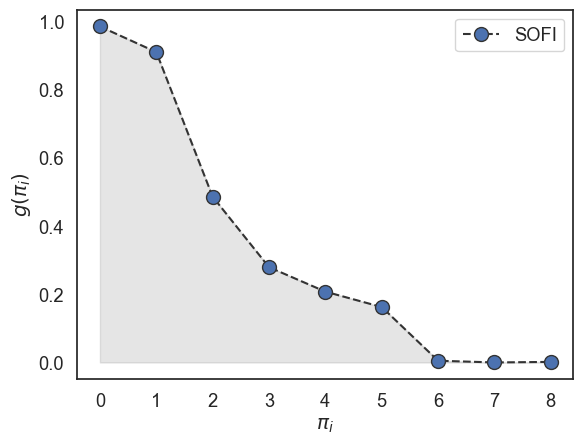

In [31]:
# plotting curve for GA only
_, ga_values = fit_value(img, mask, model, label, best_permutation)
plot_feature_flipping(['SOFI'], [ga_values], filename=None)

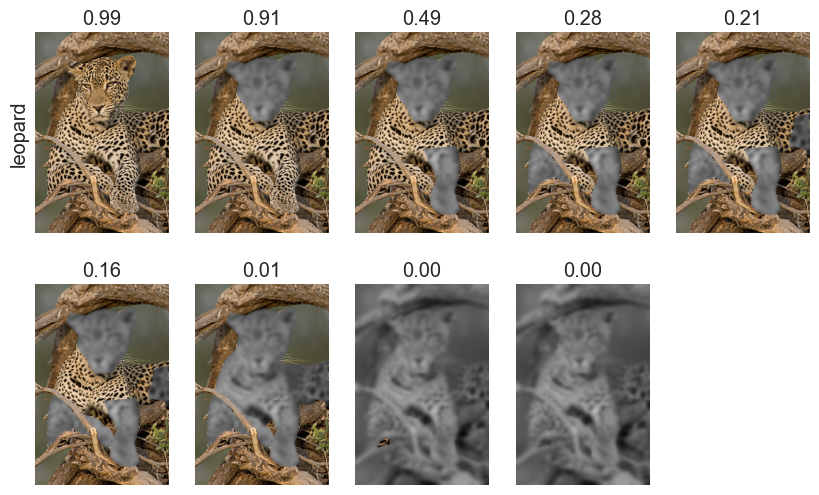

In [32]:
# blured images prediction for best permutation found by our method
display_blurred_seg_pred(img, mask, model, label, permutation=list(best_permutation), 
                         filename=img['file_name'].replace(".JPEG","")+"_sofi_blur")

In [33]:
def create_ga_score_mask(segment_mask, best_permutation, ga_values):
    
    p_list = list(best_permutation)
    
    # Get the unique segment IDs from the segment_mask
    unique_segments = np.unique(segment_mask)
    
    # Create an empty mask to store the average importance for each segment
    ga_score_mask = np.zeros_like(segment_mask, dtype=float)
    
    # Calculate the mean score for each segment
    for segment_id in unique_segments:
        
        # Mask for the current segment
        segment_mask_bool = (segment_mask == segment_id)
        
        # Compute score
        ga_score = ga_values[p_list.index(segment_id)]

        # Fill the corresponding region in the mean_score_mask
        ga_score_mask = ga_score_mask * (1 - segment_mask_bool) + ga_score * segment_mask_bool

    return ga_score_mask

In [34]:
ga_score_mask = create_ga_score_mask(mask, best_permutation, ga_values)

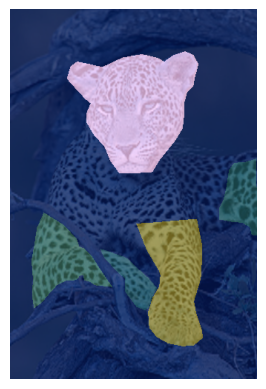

In [106]:
# displaying our scores in a mask

image_file = images_folder + img['file_name']
image_paths = [image_file]
image_batch = load_images(image_paths, model, size)
image_batch = preprocess_input(image_batch)

img_array = image_batch.numpy()

img_array = img_array.squeeze()

img_array = array_to_img(img_array)
img_array = img_array.resize((img['width'], img['height']))
img_array = img_to_array(img_array)

display_mask_over_image(img_array, ga_score_mask, alpha=0.4, filename=img['file_name'].replace(".JPEG","")+'_sofi_mask')

## GradCAM heatmap

In [98]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate a GradCAM heatmap for visualization of model activations.

    Parameters:
    - img_array (numpy.ndarray): The preprocessed image array.
    - model (tf.keras.Model): The TensorFlow Keras model.
    - last_conv_layer_name (str): The name of the last convolutional layer in the model.
    - pred_index (int, optional): The index of the predicted class. If None, the top predicted class is used.

    Returns:
    numpy.ndarray: The GradCAM heatmap for visualization.

    This function generates a GradCAM heatmap for visualizing the activations of the model.
    It computes the gradient of the top predicted class with respect to the activations of
    the last convolutional layer and uses it to create a heatmap highlighting important regions
    in the input image. The heatmap is normalized for visualization purposes.
    """
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [99]:
# testing grad_cam heatmap
last_conv_layer_name = "conv5_block3_out"

image_file = images_folder + img['file_name']
image_paths = [image_file]
image_batch = load_images(image_paths, model, size)
image_batch = preprocess_input(image_batch)

img_array = image_batch.numpy()

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

In [100]:
def display_heatmap(img, heatmap, alpha=1.0, filename=None):
    """
    Display RISE visualization on top of the original image.

    Parameters:
    - img (numpy.ndarray): The original image as a NumPy array.
    - heatmap (numpy.ndarray): The RISE heatmap corresponding to the image.
    - alpha (float, optional): The transparency factor for blending the heatmap with the original image.

    This function takes an original image and its associated RISE heatmap, colorizes the heatmap,
    and superimposes it on the original image to highlight important regions. The alpha parameter
    controls the transparency of the heatmap overlay. The resulting visualization is displayed
    using Matplotlib.
    """
   
    # Rescale heatmap to a range 0-255
    min_value = np.min(heatmap)
    max_value = np.max(heatmap)
    heatmap_rescaled = np.uint8(255 * (heatmap - min_value) / (max_value - min_value))

    # Use jet colormap to colorize heatmap
    jet = batlow_cmap

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_rescaled]

    # Resize heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Display Grad CAM
    plt.figure()
    ps = plt.imshow(superimposed_img, cmap=batlow_cmap)
#     cb = plt.colorbar(ps)
#     cb.set_ticks([])
    plt.axis('off')
    # plt.show()
    
    if filename is not None:
        plt.savefig('figures/' + filename + ".pdf", dpi=300, bbox_inches='tight')

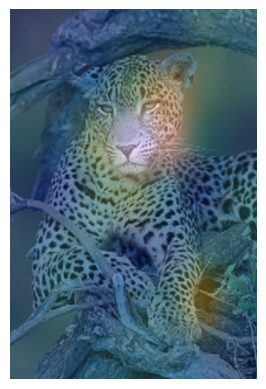

In [101]:
# testing display gradcam
# Drop the first dimension to represent a single image
img_array = img_array.squeeze()

# Resize to original for better visualization
img_array = array_to_img(img_array)
img_array = img_array.resize((img['width'], img['height']))
img_array = img_to_array(img_array)

display_heatmap(img_array, heatmap, filename=img['file_name'].replace(".JPEG","")+'_gradcam')

In [102]:
def create_mean_score_mask(segment_mask, importance_mask):
    """
    Compute the mean score mask and segment-wise scores based on importance values.

    Parameters:
    - segment_mask (numpy.ndarray): The segmentation mask containing unique segment IDs.
    - importance_mask (numpy.ndarray): The importance values corresponding to each pixel.

    Returns:
    tuple: A tuple containing the mean score mask and a dictionary of segment-wise mean scores.

    This function takes a segmentation mask and an importance mask.
    It computes the mean score mask, where each pixel represents the average importance
    value for its corresponding segment. Additionally, it calculates and returns a dictionary
    containing the mean score for each unique segment ID.
    """
    
    # Get the unique segment IDs from the segment_mask
    unique_segments = np.unique(segment_mask)
    
    # resize scores to match the image size
    scores = cv2.resize(importance_mask, (segment_mask.shape[1], segment_mask.shape[0]))
    
    seg_score = dict()

    # Create an empty mask to store the average importance for each segment
    mean_score_mask = np.zeros_like(scores, dtype=float)

    # Calculate the mean score for each segment
    for segment_id in unique_segments:
        # Mask for the current segment
        segment_mask_bool = (segment_mask == segment_id)
        
        # Compute mean score and store
        mean_score = np.mean(scores[segment_mask_bool])
        seg_score[segment_id] = mean_score

        # Fill the corresponding region in the mean_score_mask
        mean_score_mask = mean_score_mask * (1 - segment_mask_bool) + mean_score * segment_mask_bool

    return mean_score_mask, seg_score

In [103]:
# testing mean score mask
segment_mask = mask
importance_mask = heatmap

mean_score_mask, seg_score = create_mean_score_mask(segment_mask, importance_mask)

# Sort the keys based on their values in descending order
grad_cam_permutation = sorted(seg_score, key=lambda k: seg_score[k], reverse=True)
print(grad_cam_permutation)
print(seg_score)

[1, 6, 7, 4, 5, 0, 3, 2]
{0: 0.15785693, 1: 0.51663554, 2: 0.12318127, 3: 0.14804226, 4: 0.21050526, 5: 0.19811907, 6: 0.23327835, 7: 0.2196815}


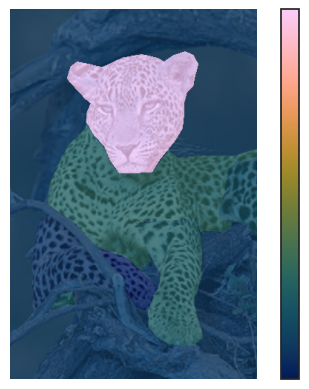

In [104]:
display_mask_over_image(img_array, mean_score_mask, alpha=0.4, 
                        filename=img['file_name'].replace(".JPEG","")+'_gradcam_mask')

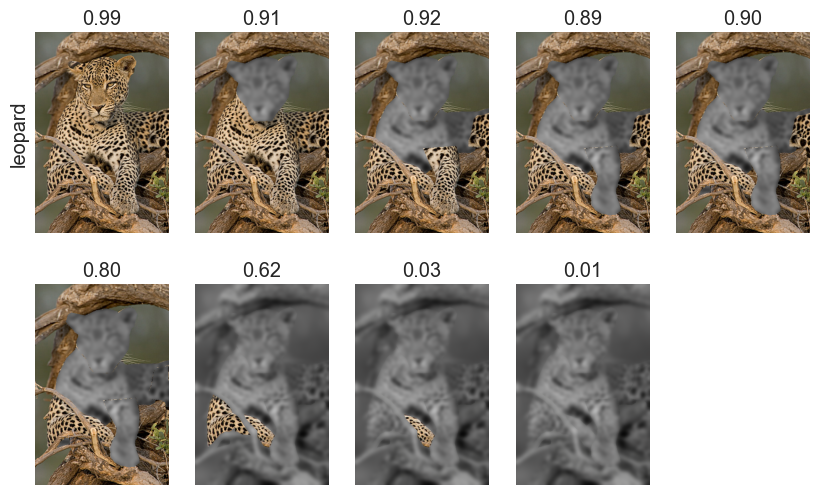

In [46]:
display_blurred_seg_pred(img, mask, model, label, permutation=list(grad_cam_permutation), 
                         filename=img['file_name'].replace(".JPEG","")+'_gradcam_blur')

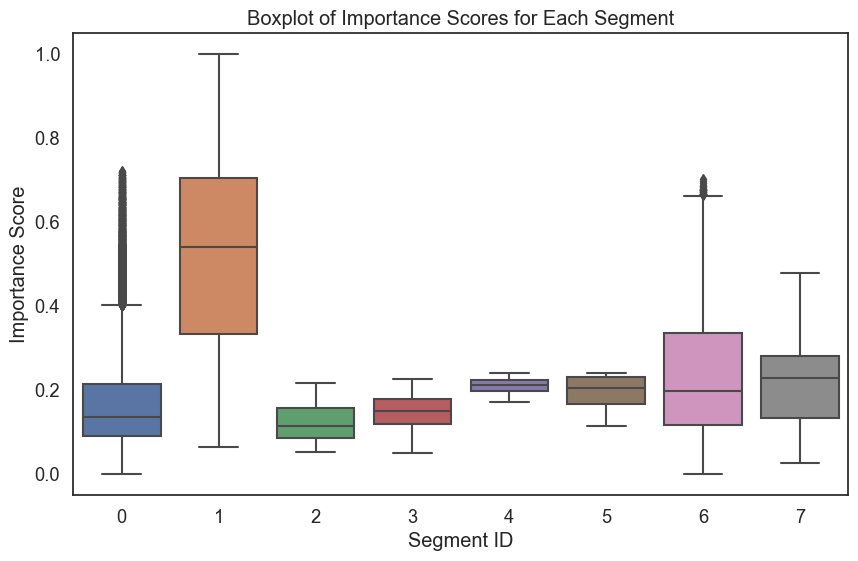

In [47]:
import pandas as pd

def plot_segment_scores_boxplot(segment_mask, importance_mask):
    """
    Plot a boxplot for each segment based on importance scores.

    Parameters:
    - segment_mask (numpy.ndarray): The segmentation mask containing unique segment IDs.
    - importance_mask (numpy.ndarray): The importance values corresponding to each pixel.

    Displays a boxplot where each box represents the distribution of importance scores
    for the pixels belonging to each unique segment in the segmentation mask.
    """
    
    # Ensure the importance mask has the same dimensions as the segment mask
    importance_mask = cv2.resize(importance_mask, (segment_mask.shape[1], segment_mask.shape[0]))
    
    # Get the unique segment IDs from the segment_mask
    unique_segments = np.unique(segment_mask)
    
    # Create a DataFrame to store scores for each segment
    data = {'Segment': [], 'Importance Score': []}

    for segment_id in unique_segments:
        # Mask for the current segment
        segment_mask_bool = (segment_mask == segment_id)
        
        # Extract importance scores for the segment
        segment_scores = importance_mask[segment_mask_bool]
        
        # Append scores to the DataFrame
        data['Segment'].extend([segment_id] * len(segment_scores))
        data['Importance Score'].extend(segment_scores)

    df = pd.DataFrame(data)

    # Plot a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Segment', y='Importance Score', data=df)
    plt.title('Boxplot of Importance Scores for Each Segment')
    plt.xlabel('Segment ID')
    plt.ylabel('Importance Score')
    plt.show()

# Example usage:
plot_segment_scores_boxplot(segment_mask, importance_mask)


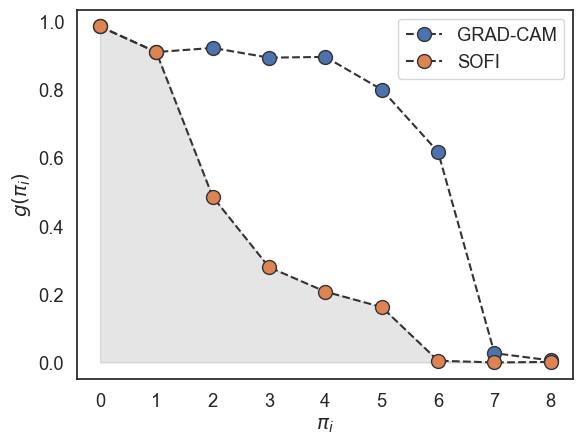

In [48]:
_, grad_values = fit_value(img, mask, model, label, grad_cam_permutation)
plot_feature_flipping(['GRAD-CAM','SOFI'], [grad_values,ga_values])

## SHAP on Resnet for Imagenet

In [49]:
image_file = images_folder + img['file_name']
image_paths = [image_file]
image_batch = load_images(image_paths, model, size)
# image_batch = preprocess_input(image_batch)

img_array = image_batch.numpy()

In [50]:
def get_shap_scores(img_array, model, class_names):
    """
    Calculate SHAP values for an input image using the SHAP library.

    Parameters:
    - img_array (numpy.ndarray): The preprocessed image array.
    - model (tf.keras.Model): The TensorFlow Keras model.
    - class_names (list): List of class names for model output interpretation.

    Returns:
    numpy.ndarray: SHAP values corresponding to the input image.

    This function uses the SHAP library to calculate SHAP values for the given input image.
    It employs an image masker to mask out partitions of the input image and creates an explainer
    with the model and image masker. The SHAP values are then calculated using 500 evaluations
    of the underlying model, and the resulting SHAP values are returned.
    """

    # define a masker that is used to mask out partitions of the input image.
    masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)
    
    # create an explainer with model and image masker
    explainer = shap.Explainer(model, masker, output_names=class_names)
    
    # explain the image using max_evals evaluations of the underlying model to estimate the SHAP values
    shap_values = explainer(img_array, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
    
    return shap_values[0,:,:,:,0].values[:,:,0], shap_values

In [51]:
shap_scores, all_shap_values = get_shap_scores(img_array, model, class_names)

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:51, 111.48s/it]                                                                  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


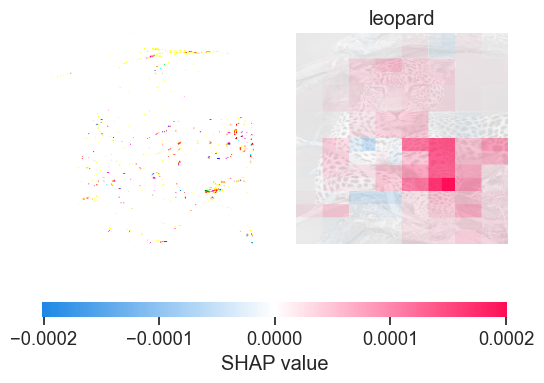

In [52]:
shap.image_plot(all_shap_values)

In [53]:
mean_score_mask, seg_score = create_mean_score_mask(segment_mask, np.abs(shap_scores))

# Sort the keys based on their values in descending order
shap_permutation = sorted(seg_score, key=lambda k: seg_score[k], reverse=True)
print(shap_permutation)
print(seg_score)

[7, 2, 5, 6, 1, 3, 0, 4]
{0: 4.549483003074036e-06, 1: 8.996570379210383e-06, 2: 1.4393098579074319e-05, 3: 5.4943484645405185e-06, 4: 2.6546787034797257e-06, 5: 1.2125155831431336e-05, 6: 1.0897692529197995e-05, 7: 2.600619097655333e-05}


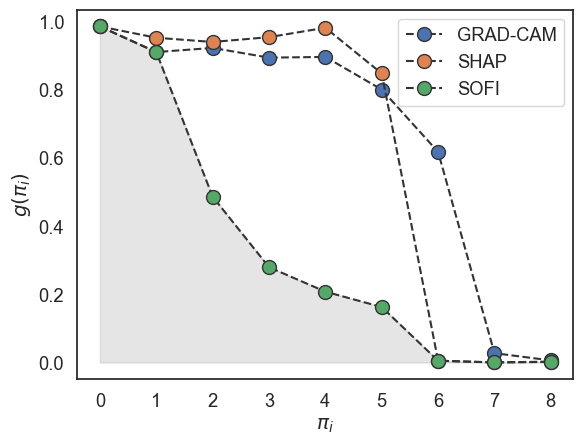

In [54]:
# plotting curve
_, gshap_values = fit_value(img, mask, model, label, shap_permutation)
plot_feature_flipping(['GRAD-CAM','SHAP','SOFI'], [grad_values,gshap_values,ga_values])

In [55]:
image_file = images_folder + img['file_name']
image_paths = [image_file]
image_batch = load_images(image_paths, model, size)
image_batch = preprocess_input(image_batch)

img_array = image_batch.numpy()

img_array = img_array.squeeze()

img_array = array_to_img(img_array)
img_array = img_array.resize((img['width'], img['height']))
img_array = img_to_array(img_array)

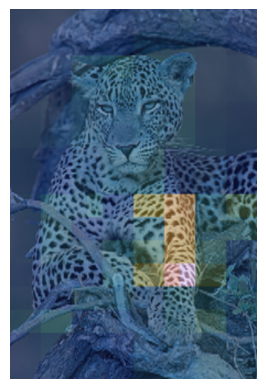

In [56]:
display_heatmap(img_array, np.abs(shap_scores), filename=img['file_name'].replace(".JPEG","")+'_shap')

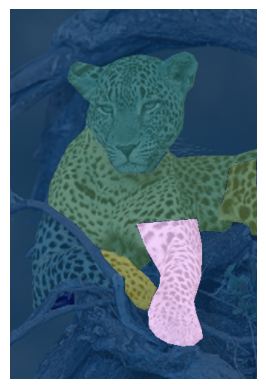

In [57]:
display_mask_over_image(img_array, mean_score_mask, alpha=0.4, 
                        filename=img['file_name'].replace(".JPEG","")+'_shap_mask')

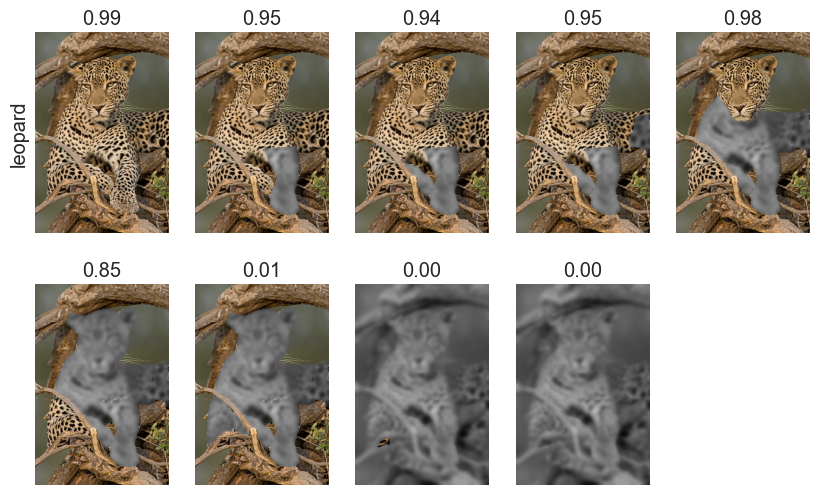

In [58]:
display_blurred_seg_pred(img, mask, model, label, permutation=list(shap_permutation), 
                         filename=img['file_name'].replace(".JPEG","")+'_shap_blur')

## RISE on Resnet for Imagenet

In [59]:
def generate_masks(N, s, p1):
    
    cell_size = np.ceil(np.array(size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + size[0], y:y + size[1]]
    masks = masks.reshape(-1, *size, 1)
    return masks

batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.predict(masked[i: min(i + batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *size)
    sal = sal / N / p1
    return sal

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [60]:
from keras.preprocessing import image

def load_img(path):
    img = image.load_img(path, target_size=size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

image_file = images_folder + img['file_name']
img_array, x = load_img(image_file)

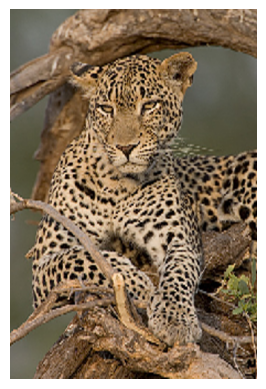

In [61]:
img_array = array_to_img(img_array)
img_array = img_array.resize((img['width'], img['height']))
img_array = img_to_array(img_array)

plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

In [62]:
N = 2000 #
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|███████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 301.51it/s]


In [63]:
sal = explain(model, x, masks)

Explaining:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

4/4 [==============================] - 8s 2s/step


Explaining:   5%|███▌                                                                   | 1/20 [00:07<02:26,  7.73s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  10%|███████                                                                | 2/20 [00:15<02:22,  7.93s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  15%|██████████▋                                                            | 3/20 [00:23<02:15,  7.95s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  20%|██████████████▏                                                        | 4/20 [00:32<02:09,  8.07s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  25%|█████████████████▊                                                     | 5/20 [00:40<02:04,  8.32s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  30%|█████████████████████▎                                                 | 6/20 [00:48<01:53,  8.11s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  35%|████████████████████████▊                                              | 7/20 [00:56<01:43,  7.99s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  40%|████████████████████████████▍                                          | 8/20 [01:03<01:34,  7.91s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  45%|███████████████████████████████▉                                       | 9/20 [01:12<01:28,  8.04s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  50%|███████████████████████████████████                                   | 10/20 [01:20<01:19,  7.96s/it]

4/4 [==============================] - 9s 2s/step


Explaining:  55%|██████████████████████████████████████▌                               | 11/20 [01:28<01:13,  8.20s/it]

4/4 [==============================] - 9s 2s/step


Explaining:  60%|██████████████████████████████████████████                            | 12/20 [01:38<01:08,  8.55s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  65%|█████████████████████████████████████████████▌                        | 13/20 [01:47<01:01,  8.84s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  70%|█████████████████████████████████████████████████                     | 14/20 [01:56<00:53,  8.85s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  75%|████████████████████████████████████████████████████▌                 | 15/20 [02:04<00:43,  8.66s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  80%|████████████████████████████████████████████████████████              | 16/20 [02:12<00:33,  8.49s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  85%|███████████████████████████████████████████████████████████▌          | 17/20 [02:21<00:25,  8.40s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  90%|███████████████████████████████████████████████████████████████       | 18/20 [02:29<00:16,  8.26s/it]

4/4 [==============================] - 8s 2s/step


Explaining:  95%|██████████████████████████████████████████████████████████████████▌   | 19/20 [02:37<00:08,  8.30s/it]

4/4 [==============================] - 7s 2s/step


Explaining: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.25s/it]


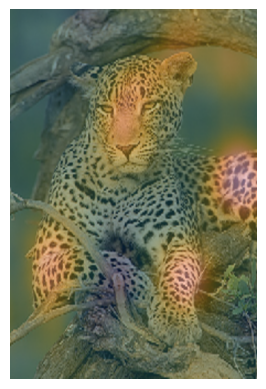

In [64]:
# Resize to original for better visualization
img_array = array_to_img(img_array)
img_array = img_array.resize((img['width'], img['height']))
img_array = img_to_array(img_array)

class_idx = class_names.index(label)

display_heatmap(img_array, sal[class_idx], 
             filename=img['file_name'].replace(".JPEG","")+'_rise') 

In [65]:
importance_mask = sal[class_idx]

mean_score_mask, seg_score = create_mean_score_mask(segment_mask, importance_mask)

# Sort the keys based on their values in descending order
rise_permutation = sorted(seg_score, key=lambda k: seg_score[k], reverse=True)
print(rise_permutation)
print(seg_score)

[5, 3, 7, 1, 4, 6, 0, 2]
{0: 0.5516974260215165, 1: 0.5702507747741985, 2: 0.533017763483473, 3: 0.5754837174346815, 4: 0.5677016713134111, 5: 0.6003723042003722, 6: 0.5525501129084833, 7: 0.5713419091021557}


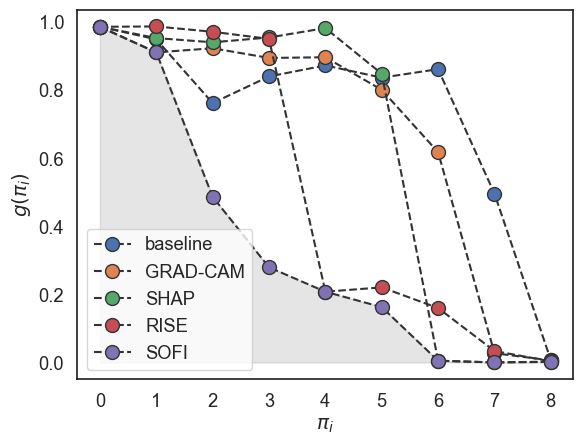

In [66]:
# plotting curve
_, rise_values = fit_value(img, mask, model, label, rise_permutation)
_, baseline_values = fit_value(img, mask, model, label, [0,1,2,3,4,5,6,7])
plot_feature_flipping(['baseline','GRAD-CAM','SHAP','RISE','SOFI'], [baseline_values, grad_values, gshap_values, rise_values, ga_values], 
                      filename=img['file_name'].replace(".JPEG","")+'_plot')

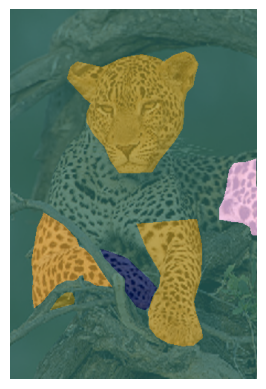

In [67]:
display_mask_over_image(img_array, mean_score_mask, alpha=0.4, 
                        filename=img['file_name'].replace(".JPEG","")+'_rise_mask')

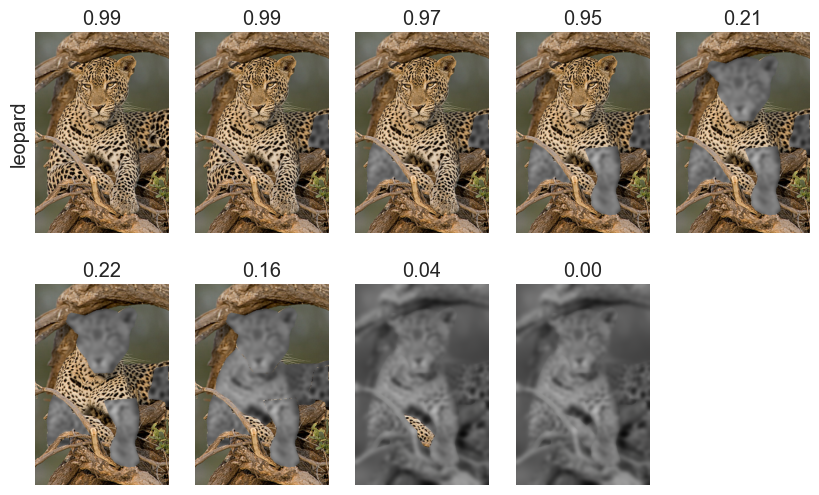

In [68]:
display_blurred_seg_pred(img, mask, model, label, permutation=list(rise_permutation), 
                         filename=img['file_name'].replace(".JPEG","")+'_rise_blur')